<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº3: Estimación Espectral y Ventanas
#### Ariel Hipólito


# Introducción:

En este notebook se simula una señal senoidal ruidosa y se estudia la 
estimación de amplitud y frecuencia utilizando la Transformada Discreta de Fourier (DFT) 
con distintas ventanas (rectangular, Hann, Blackman-Harris y Flattop).  

El objetivo es analizar el sesgo y la varianza de los estimadores bajo distintos 
niveles de relación señal-ruido (SNR = 3 dB y 10 dB).

## Modelo de señal

La señal simulada se define como:



\begin{equation}
x(n) = a_0 \cdot \sin(\Omega_1 n) + n_q(n)
\end{equation}



Donde:
- $ a_0 = \sqrt{2}$ : es la amplitud (potencia = 1 W).
- $\Omega_0 = \frac{\pi}{2}$ : es la frecuencia central.
- $\Omega_1 = \Omega_0 + f_r \cdot \frac{\pi}{2N}$, con  $f_r \sim U(-2, 2)$
- $ n_q(n) \sim \mathcal{N}(0, \sigma^2)$ es ruido blanco gaussiano.

Se simulan 200 realizaciones de 1000 muestras cada una, para dos niveles de SNR: 3 dB y 10 dB.

Primero vamos abordar ciertos temas como el **zero-ṕadding** y la **normalización de amplitud** de las señales.

- - - 

## ZERO-PADDING:

Es una tecnica que consiste basicamente en **agregar ceros al final de la señal en el dominio temporal** antes de calcular la FFT con el fin de mejorar la estimación de frecuencia de picos y obtener graficos más claros para comparar con mayor detalle ventanas y efectos de desparramo hacia frecuencias vecinas por lo que la energía de una señal no se concentra en un único bin de la DFT (*leakage*).

La DFT de longitud $N$ evalúa la transformada de Fourier en $N$ frecuencias discretas.
Si se aumenta a $N_{fft} > N$ se obtienen más puntos en la grilla de frecuencias.
Es decir, la FFT queda más “densa” por lo que te da mejor visualización de los picos.

\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-j \frac{2\pi kn}{N}}
\end{equation}

Si se extiende a $N_{fft}$, la definición es la misma, pero se evalúa en una grilla de frecuencias más fina: $\Delta \omega = \frac{2\pi}{N_{fft}}$

Interpolando la DFT se logra ubicar mejor el pico real dado que $\Delta f = \frac{f_s}{N}$ por lo que mientras mas grande sea nuestro $N$ mas acotado será nuestro $\Delta f$.

Y todo esto lo hace sin:

- Cambiar la información real de la señal.
- Mejorar la relación señal-ruido (SNR).
- Aumentar la resolución física del muestreo.

- - -

## NORMALIZACION DE LA AMPLITUD: 

Cuando se realiza la FFT de una señal $x[n]$, el valor que aparece en un bin $k$ no es directamente la amplitud de la senoidal.

\begin{equation}
x[n] = a \cdot \sin(\omega_0 n), \quad n = 0, \ldots, N - 1
\end{equation}

Si se aplica la FFT (sin ventana, sin ruido, sin normalización) y justo la frecuencia coincide con un bin, el valor de ese bin va a ser aproximadamente:

\begin{equation}
|X[k_0]| \approx \frac{a \cdot N}{2}
\end{equation}

Es decir la magnitud en el dominio frecuencial crece con $N$ y no es igual a $a$ por lo que para que el estimador de amplitud sea consistente con el valor real de la senoidal es necesario dividir por ese factor.

Cuando además se aplica una ventana $w[n]$ (Hann, Blackman, etc.), ya no se tiene la suma exacta, sino que cada muestra se multiplica por un coeficiente distinto.

Entonces el valor del bin se aproxima a:
\begin{equation}
|X[k_0]| \approx \frac{a \cdot N \cdot G_w}{2} ; \quad G_w = \frac{1}{N} \sum_{n=0}^{N-1} w[n]
\end{equation}

Siendo $G_w$ la ganancia coherente de la ventana (básicamente cuánto “baja” la amplitud de la senoidal al aplicar esa ventana).

Teniendo esto en cuenta podremos obtener un estimador insesgado de la amplitud real $a$, haciendo la corrección inversa:
\begin{equation}
\hat{a} = \frac{2}{N \cdot G_w} \cdot |X_w[k_0]|
\end{equation}

De esta manera evitamos resultados engañosos dado que si no se realizara la normalizacion:
- Los histogramas y valores de sesgo/varianza de amplitud van a estar desplazados respecto al valor verdadero $a$.
- El estimador daría amplitudes mucho más grandes o más chicas, dependiendo de $N$ y de la ventana elegida.

Por ejemplo si tuvieramos una señal de amplitud $a=1$, con $N=1000$ y con una ventana rectangular donde $G_w=1$. El bin de FFT daría $∣X[k0]∣≈500$. Es decir que sin la normalización la amplitud sería 500 en lugar de 1.

- - -

Empezaremos declarando las variables globales: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import get_window

# Parámetros globales
N = 1000
M = 200
fs = N
omega0 = np.pi / 2
a0 = np.sqrt(2)
SNR_dbs = [3, 10]

# Ventanas a analizar
ventanas = {
    "rectangular": np.ones(N),
    "flattop": get_window("flattop", N),
    "blackmanharris": get_window("blackmanharris", N),
    "hann": get_window("hann", N)
}

tt = np.arange(N)

## Simulación y estimación

Se genera la señal senoidal con ruido para cada realización, y se aplica cada ventana antes de calcular la FFT. Luego se estiman:

- **Amplitud**: usando el valor de la FFT en $\Omega_0$
- **Frecuencia**: como el índice del máximo espectral.

Se calculan el sesgo y la varianza de cada estimador para cada ventana y SNR sin tener en cuenta el zero-padding ni la ganancia de la ventana.


In [15]:
def superposicion_show(snr_dbs, N_fft):
    
    for snr_db in snr_dbs:
        
        print(f"\n### Simulación con SNR = {snr_db} dB ###\n")

        #Varianza del ruido para el SNR prescrito
        sigma2 = a0**2 / (2*(10**(snr_db/10)))

        # Frecuencias aleatorias alrededor de omega0
        frs = np.random.uniform(-2, 2, M)
        omega1 = omega0 + frs * 2 * np.pi / N
    
        # Expandir dimensiones
        tt_matricial = np.tile(tt.reshape(N, 1), (1, M))
        omega1_matricial = np.tile(omega1.reshape(1, M), (N, 1))
        
        # Señal senoidal + ruido
        sin = a0 * np.sin(omega1_matricial * tt_matricial)
        ruido = np.random.normal(0, np.sqrt(sigma2), (N, M))
        sin_ruidosa = sin + ruido
        
        freqs = np.fft.fftfreq(N_fft, d=1)[0:N_fft//2] * N
    
        # Gráficos
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        axs = axs.flatten()
    
        for i, (nombre, w) in enumerate(ventanas.items()):
            # Aplicar ventana
            w_matricial = np.tile(w.reshape(N,1), (1, M))
            sin_w = sin_ruidosa * w_matricial
            
            # FFT
            Xw = np.fft.fft(sin_w, N_fft, axis=0)
            mag = np.abs(Xw[0:N_fft//2, :]) 
            mag = mag / np.max(mag, axis=0, keepdims=True)
    
            #Graficar cada realización
            for j in range(M):
                axs[i].plot(freqs[:N_fft//2], mag[:, j])
    
            axs[i].set_title(f"Ventana {nombre} - Superposición de {M} fits")
            axs[i].set_xlim(240, 260)
            axs[i].set_ylim(0, 1.1)
            axs[i].set_xlabel("Frecuencia (muestras)")
            axs[i].set_ylabel("Magnitud normalizada")
    
        plt.tight_layout()
        plt.show()
    return 


### Simulación con SNR = 3 dB ###



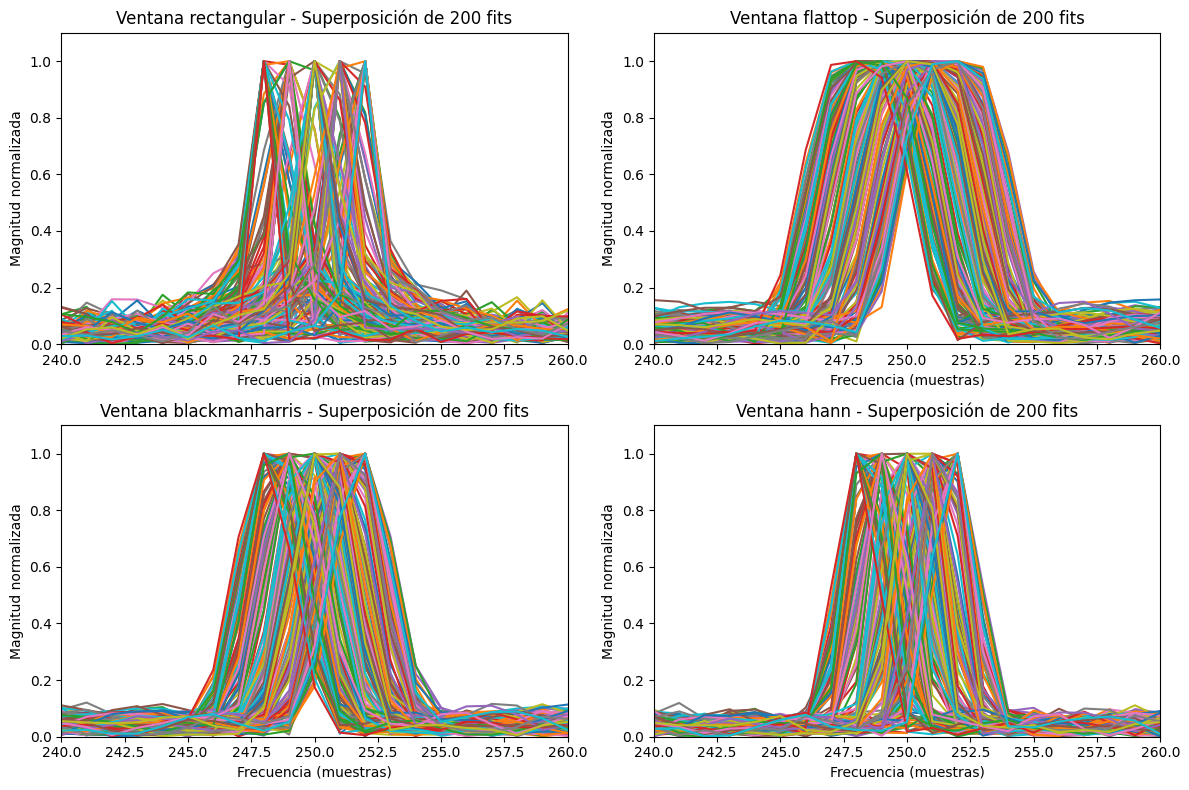


### Simulación con SNR = 10 dB ###



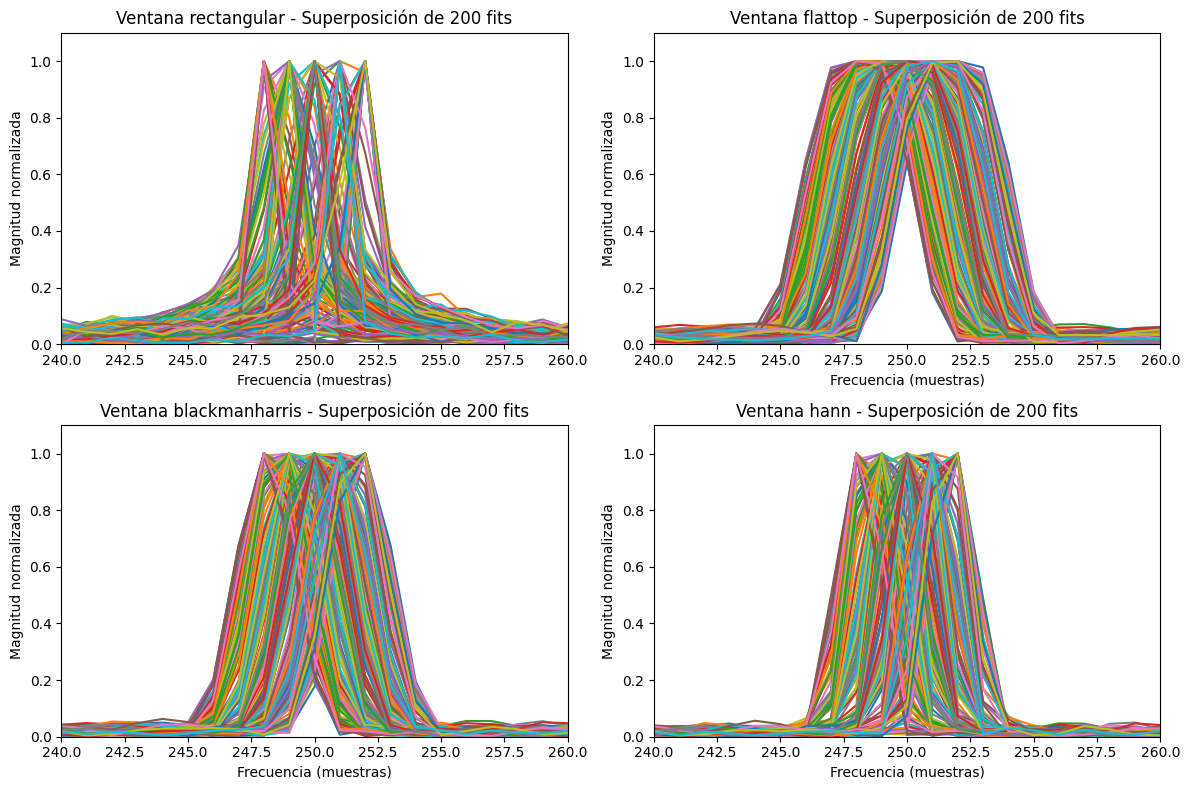

In [16]:
superposicion_show(SNR_dbs, N_fft=N)

In [33]:
def estimadores_show(snr_dbs, ventanas, N_fft, normalizado="si"):
    # DataFrames acumuladores
    resultados_amp = []
    resultados_freq = []
    
    colores = {
        "rectangular": "steelblue",
        "flattop": "orange",
        "blackmanharris": "green",
        "hann": "red"
    }
    
    for snr_db in snr_dbs:
        print(f"\n### Simulación con SNR = {snr_db} dB ###\n")

        # Varianza del ruido para el SNR prescrito
        sigma2 = a0**2 / (2*(10**(snr_db/10)))

        # Frecuencias aleatorias alrededor de omega0
        frs = np.random.uniform(-2, 2, M)
        omega1 = omega0 + frs * 2 * np.pi / N

        # Expandir dimensiones
        tt_matricial = np.tile(tt.reshape(N, 1), (1, M))
        omega1_matricial = np.tile(omega1.reshape(1, M), (N, 1))

        # Señal senoidal + ruido
        sin = a0 * np.sin(omega1_matricial * tt_matricial)
        ruido = np.random.normal(0, np.sqrt(sigma2), (N, M))
        sin_ruidosa = sin + ruido

        # Acumuladores de histogramas
        hist_amp = {}
        hist_freq = {}

        for nombre, w in ventanas.items():
            print(f"  Ventana: {nombre}\n")

            # Aplicar ventana
            w_matricial = np.tile(w.reshape(N,1), (1, M))
            sin_w = sin_ruidosa * w_matricial

            # FFT
            Xw = np.fft.fft(sin_w, N_fft, axis=0)

            # Solo mitad positiva del espectro
            freqs = np.fft.fftfreq(N_fft, d=1/fs)
            pos_mask = freqs >= 0
            freqs = freqs[pos_mask]
            Xw = Xw[pos_mask, :]

            # Estimadores
            idx0 = np.argmin(np.abs(freqs - omega0 * fs/(2*np.pi)))  # en Hz
            if normalizado == "si":
                Gw = np.sum(w) / N   # Ganancia de la ventana
                estim_amplitud = (2 / (N * Gw)) * np.abs(Xw[idx0, :])
            else: 
                estim_amplitud = np.abs(Xw[idx0, :])

            idx_max = np.argmax(np.abs(Xw), axis=0)
            estim_frec = freqs[idx_max]

            # Estadísticos
            mu_a = np.mean(estim_amplitud)
            sesgo_a = mu_a - a0
            var_a = np.var(estim_amplitud)

            mu_f = np.mean(estim_frec)
            mu_f_teo = np.mean(omega1 * fs / (2*np.pi))  # frecuencia real en Hz
            sesgo_f = mu_f - mu_f_teo
            var_f = np.var(estim_frec)

            print(f"    Amplitud: sesgo={sesgo_a:.4f}, var={var_a:.4f}")
            print(f"    Frecuencia: sesgo={sesgo_f:.4e}, var={var_f:.4e}\n")

            # Guardar resultados
            resultados_amp.append([snr_db, nombre, sesgo_a, var_a])
            resultados_freq.append([snr_db, nombre, sesgo_f, var_f])

            # Guardar datos para histogramas
            hist_amp[nombre] = estim_amplitud
            hist_freq[nombre] = estim_frec

        # === Graficar superpuestos ===
        plt.figure(figsize=(12,5))

        # Amplitud
        plt.subplot(1,2,1)
        for nombre, datos in hist_amp.items():
            plt.hist(datos, bins=20, alpha=0.5, label=nombre, color=colores[nombre])
        plt.title(f"Histograma Amplitud estimada\nSNR={snr_db} dB")
        plt.xlabel("Amplitud")
        plt.ylabel("Frecuencia")
        plt.legend()

        # Frecuencia
        plt.subplot(1,2,2)
        for nombre, datos in hist_freq.items():
            plt.hist(datos, bins=20, alpha=0.5, label=nombre, color=colores[nombre])
        plt.title(f"Histograma Frecuencia estimada\nSNR={snr_db} dB")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Frecuencia")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # DataFrames finales
    df_amp = pd.DataFrame(resultados_amp, columns=["SNR [dB]", "Ventana", "Sesgo", "Varianza"])
    df_freq = pd.DataFrame(resultados_freq, columns=["SNR [dB]", "Ventana", "Sesgo", "Varianza"])

    print("\n=== Estimación de Amplitud ===")
    display(df_amp)

    print("\n=== Estimación de Frecuencia ===")
    display(df_freq)

    return df_amp, df_freq




### Simulación con SNR = 3 dB ###

  Ventana: rectangular

    Amplitud: sesgo=241.4748, var=44172.2180
    Frecuencia: sesgo=1.5488e-02, var=1.4694e+00

  Ventana: flattop

    Amplitud: sesgo=139.1212, var=256.4473
    Frecuencia: sesgo=5.4877e-03, var=1.4078e+00

  Ventana: blackmanharris

    Amplitud: sesgo=163.7425, var=4062.8950
    Frecuencia: sesgo=1.0488e-02, var=1.5036e+00

  Ventana: hann

    Amplitud: sesgo=174.8017, var=13384.3210
    Frecuencia: sesgo=1.5488e-02, var=1.4894e+00



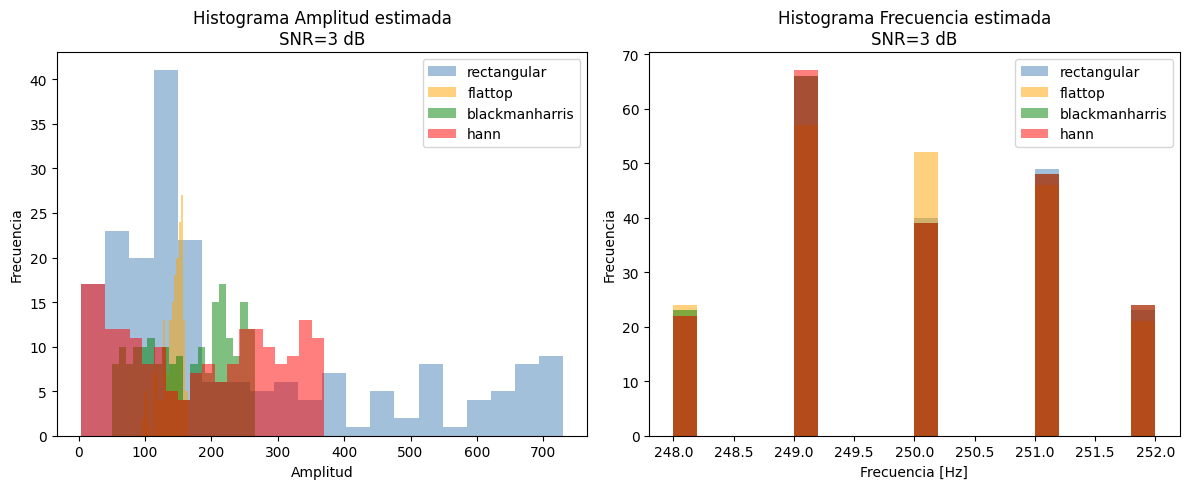


### Simulación con SNR = 10 dB ###

  Ventana: rectangular

    Amplitud: sesgo=288.1874, var=57999.7765
    Frecuencia: sesgo=3.3170e-03, var=1.3620e+00

  Ventana: flattop

    Amplitud: sesgo=138.8835, var=242.4485
    Frecuencia: sesgo=-1.6683e-02, var=1.3694e+00

  Ventana: blackmanharris

    Amplitud: sesgo=170.7402, var=4573.6935
    Frecuencia: sesgo=8.3170e-03, var=1.3475e+00

  Ventana: hann

    Amplitud: sesgo=190.2207, var=15562.4200
    Frecuencia: sesgo=3.3170e-03, var=1.3620e+00



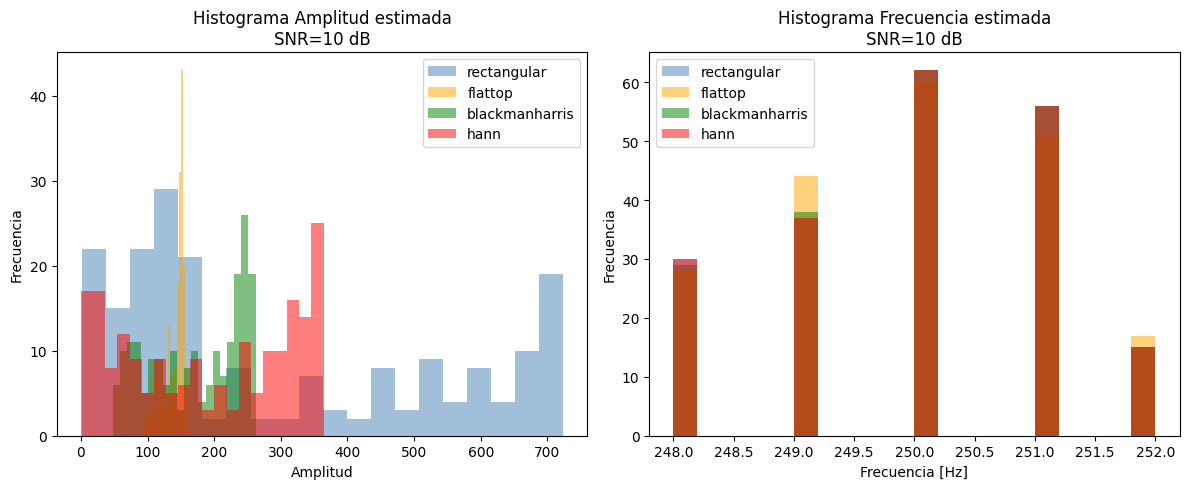


=== Estimación de Amplitud ===


,SNR [dB],Ventana,Sesgo,Varianza
0,3,rectangular,241.474814,44172.218007
1,3,flattop,139.121231,256.447343
2,3,blackmanharris,163.742454,4062.894959
3,3,hann,174.801678,13384.321035
4,10,rectangular,288.187395,57999.776500
5,10,flattop,138.883458,242.448543
6,10,blackmanharris,170.740180,4573.693482
7,10,hann,190.220724,15562.419980



=== Estimación de Frecuencia ===


,SNR [dB],Ventana,Sesgo,Varianza
0,3,rectangular,0.015488,1.469375
1,3,flattop,0.005488,1.407775
2,3,blackmanharris,0.010488,1.503600
3,3,hann,0.015488,1.489375
4,10,rectangular,0.003317,1.361975
5,10,flattop,-0.016683,1.369375
6,10,blackmanharris,0.008317,1.347500
7,10,hann,0.003317,1.361975


(   SNR [dB]         Ventana       Sesgo      Varianza
 0         3     rectangular  241.474814  44172.218007
 1         3         flattop  139.121231    256.447343
 2         3  blackmanharris  163.742454   4062.894959
 3         3            hann  174.801678  13384.321035
 4        10     rectangular  288.187395  57999.776500
 5        10         flattop  138.883458    242.448543
 6        10  blackmanharris  170.740180   4573.693482
 7        10            hann  190.220724  15562.419980,
    SNR [dB]         Ventana     Sesgo  Varianza
 0         3     rectangular  0.015488  1.469375
 1         3         flattop  0.005488  1.407775
 2         3  blackmanharris  0.010488  1.503600
 3         3            hann  0.015488  1.489375
 4        10     rectangular  0.003317  1.361975
 5        10         flattop -0.016683  1.369375
 6        10  blackmanharris  0.008317  1.347500
 7        10            hann  0.003317  1.361975)

In [34]:
estimadores_show(SNR_dbs, ventanas, N_fft=N, normalizado="no") 

Se observa como varia drasticamente el sesgo y la varianza **afectando significativamente al estimador de amplitud** pero se mantiene practicamente **invariante para el estimador de frecuencia**. Esto se debe a que ambos fenomenos afectan de manera distinta a los estimadores: 

### ESTIMADOR DE AMPLITUD: 
- Cuando aplicás una **ventana** $w[n]$, estás multiplicando la señal por algo que no es constante (excepto la rectangular).Esa multiplicación en el tiempo equivale a una **convolución en frecuencia** entre el espectro ideal de la senoidal (un delta) y la transformada de la ventana.
- Como consecuencia, la energía de la senoidal se reparte produciendo que el pico principal disminuya.
- La magnitud del coeficiente DFT ya no corresponde directamente a la amplitud real de la señal, a menos que normalices por la ganancia de la ventana

Por eso el **estimador de amplitud es muy sensible** frente a cualquier ventana distinta a la rectangular se introduce un sesgo significativo si no se compensa.

### ESTIMADOR DE FRECUENCIA: 
- La ubicación del máximo espectral (el índice $k_0$) **no depende de la altura del lóbulo principal**, sino de su posición en el eje de frecuencias.
- Ni el zero-padding ni la normalización alteran esa posición:
    - El **zero-padding** solo interpola el espectro → más puntos en frecuencia, mejor definición numérica, pero no mueve el pico real.
    - La **normalización** es un escalado en magnitud → no cambia dónde está el máximo.
- Las ventanas influyen sobre la **resolución en frecuencia** (ancho del lóbulo principal y nivel de lóbulos laterales), pero no sobre la frecuencia central de la senoidal.

Es por eso el **estimador de frecuencia se mantiene prácticamente invariante**, salvo pequeñas variaciones si el pico cae “entre bins” y hay *leakage*.

A continuacion volveremos a realizar el experimento pero esta vez teniendo en cuenta ambos efectos para demostrar como mejora. 


### Simulación con SNR = 3 dB ###



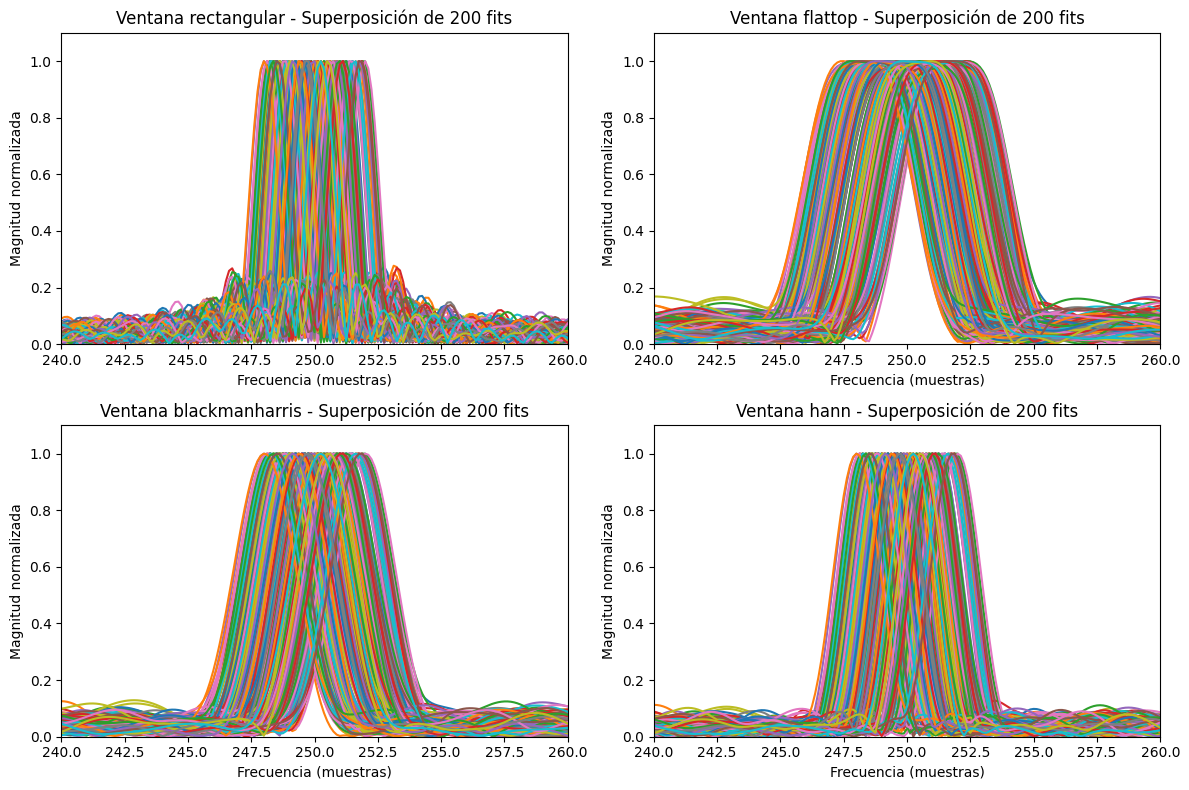


### Simulación con SNR = 10 dB ###



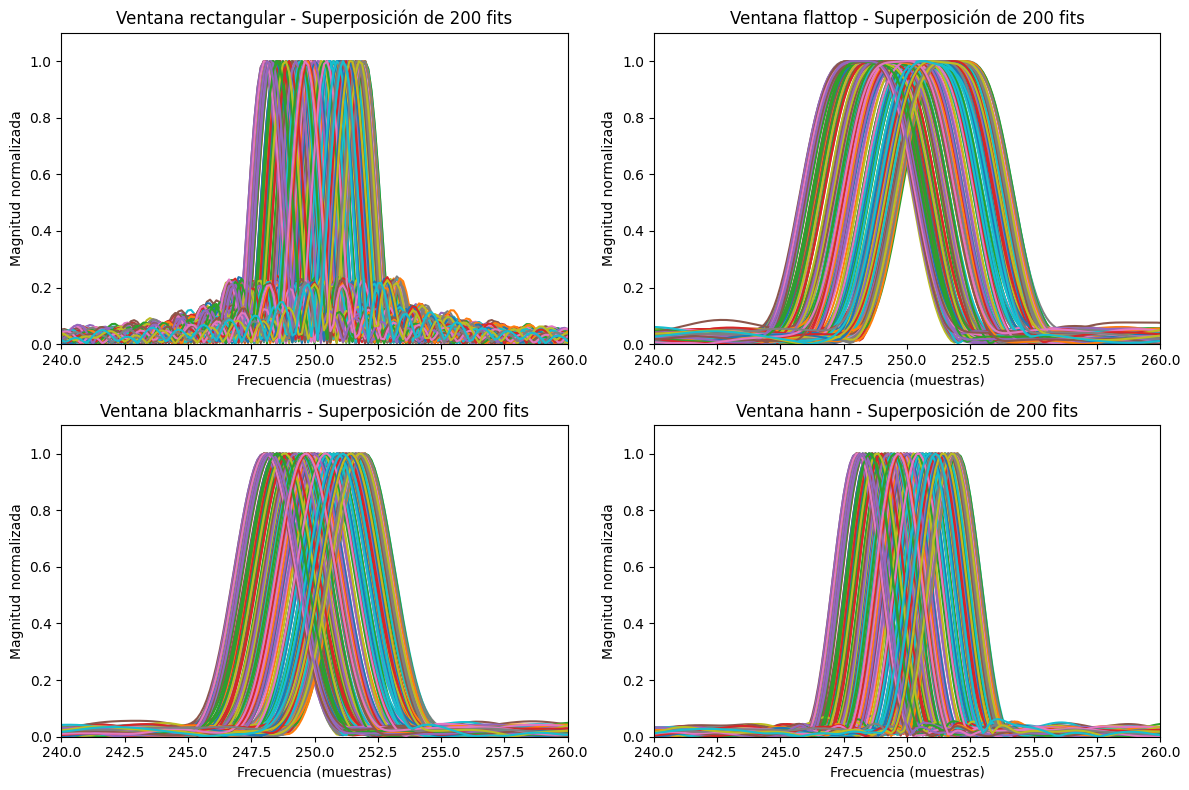

In [37]:
superposicion_show(SNR_dbs, N_fft=N*8) 


### Simulación con SNR = 3 dB ###

  Ventana: rectangular

    Amplitud: sesgo=-0.9125, var=0.1976
    Frecuencia: sesgo=-4.5660e-04, var=1.2683e+00

  Ventana: flattop

    Amplitud: sesgo=-0.1133, var=0.0237
    Frecuencia: sesgo=1.0168e-02, var=1.6629e+00

  Ventana: blackmanharris

    Amplitud: sesgo=-0.4739, var=0.1292
    Frecuencia: sesgo=-4.2066e-03, var=1.2649e+00

  Ventana: hann

    Amplitud: sesgo=-0.6778, var=0.2163
    Frecuencia: sesgo=-4.8316e-03, var=1.2647e+00



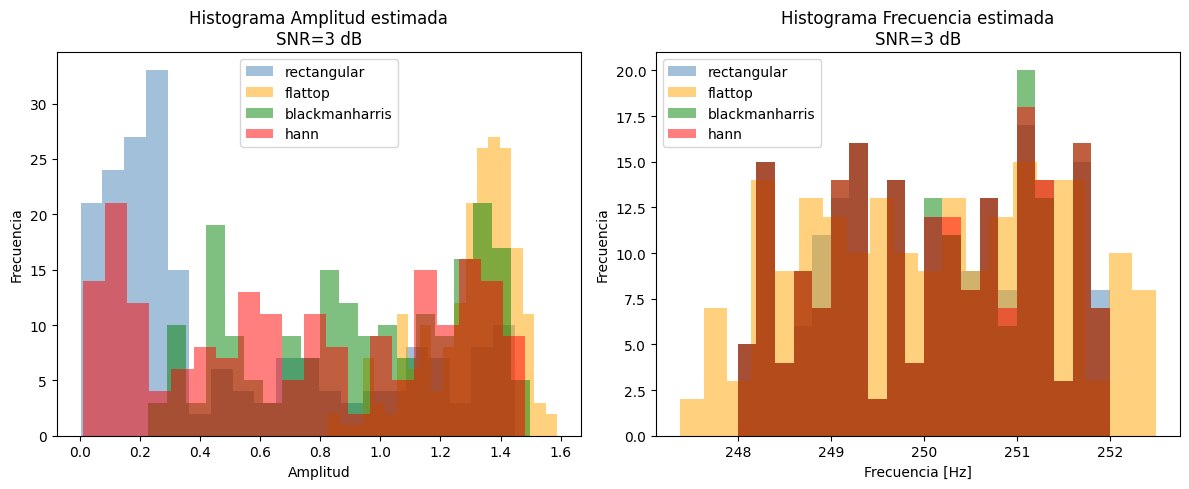


### Simulación con SNR = 10 dB ###

  Ventana: rectangular

    Amplitud: sesgo=-0.9080, var=0.1973
    Frecuencia: sesgo=5.8928e-04, var=1.4701e+00

  Ventana: flattop

    Amplitud: sesgo=-0.1415, var=0.0261
    Frecuencia: sesgo=2.8089e-02, var=1.5806e+00

  Ventana: blackmanharris

    Amplitud: sesgo=-0.5241, var=0.1501
    Frecuencia: sesgo=-3.5724e-05, var=1.4706e+00

  Ventana: hann

    Amplitud: sesgo=-0.7356, var=0.2506
    Frecuencia: sesgo=-3.5724e-05, var=1.4688e+00



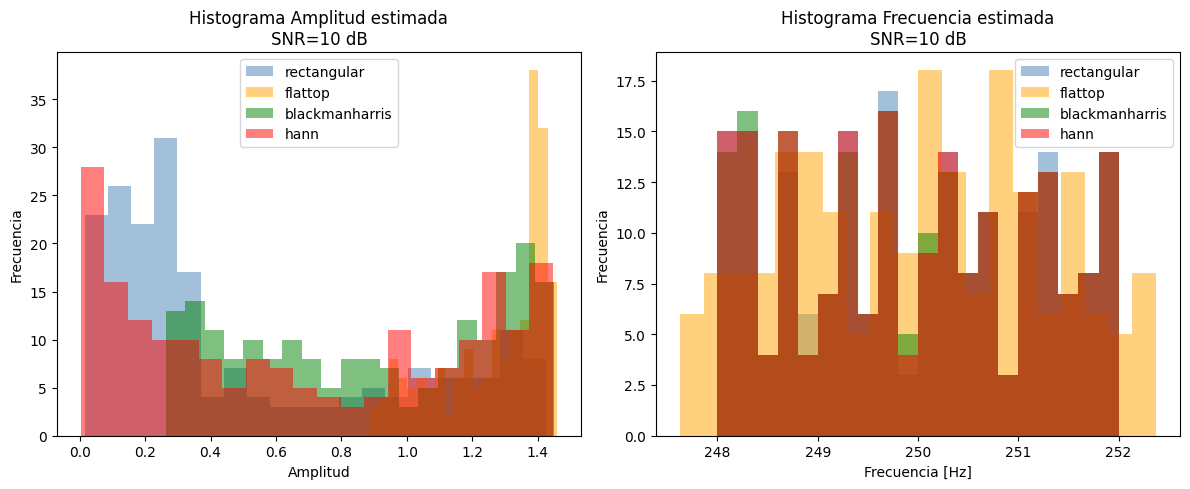


=== Estimación de Amplitud ===


,SNR [dB],Ventana,Sesgo,Varianza
0,3,rectangular,-0.912520,0.197642
1,3,flattop,-0.113306,0.023661
2,3,blackmanharris,-0.473914,0.129160
3,3,hann,-0.677811,0.216278
4,10,rectangular,-0.908045,0.197307
5,10,flattop,-0.141515,0.026097
6,10,blackmanharris,-0.524068,0.150056
7,10,hann,-0.735641,0.250625



=== Estimación de Frecuencia ===


,SNR [dB],Ventana,Sesgo,Varianza
0,3,rectangular,-0.000457,1.268350
1,3,flattop,0.010168,1.662905
2,3,blackmanharris,-0.004207,1.264859
3,3,hann,-0.004832,1.264717
4,10,rectangular,0.000589,1.470068
5,10,flattop,0.028089,1.580640
6,10,blackmanharris,-0.000036,1.470556
7,10,hann,-0.000036,1.468838


(   SNR [dB]         Ventana     Sesgo  Varianza
 0         3     rectangular -0.912520  0.197642
 1         3         flattop -0.113306  0.023661
 2         3  blackmanharris -0.473914  0.129160
 3         3            hann -0.677811  0.216278
 4        10     rectangular -0.908045  0.197307
 5        10         flattop -0.141515  0.026097
 6        10  blackmanharris -0.524068  0.150056
 7        10            hann -0.735641  0.250625,
    SNR [dB]         Ventana     Sesgo  Varianza
 0         3     rectangular -0.000457  1.268350
 1         3         flattop  0.010168  1.662905
 2         3  blackmanharris -0.004207  1.264859
 3         3            hann -0.004832  1.264717
 4        10     rectangular  0.000589  1.470068
 5        10         flattop  0.028089  1.580640
 6        10  blackmanharris -0.000036  1.470556
 7        10            hann -0.000036  1.468838)

In [38]:
estimadores_show(SNR_dbs, ventanas, N_fft=N*8, normalizado="si") 

# ESTIMADORES ALTERNATIVOS: 

Para la estimacion alternativa de la amplitud utilizaremos **"promedio en vecinos del bin principal"** y para el de la frecuencia **"interpolación parabólica en el espectro"**

### AMPLITUD: 
Cuando la frecuencia de una componente no coincide exactamente con un bin de la DFT, la energía se reparte entre varios bins. Para mejorar la estimación de la amplitud, se propone promediar los valores de magnitud en los bins vecinos al máximo. Este método reduce el sesgo causado por la fuga espectral.

\begin{equation}
\hat{A} = \frac{1}{3} \left( |X[k_0 - 1]| + |X[k_0]| + |X[k_0 + 1]| \right)
\end{equation}

### FRECUENCIA: 
La interpolación parabólica permite estimar la frecuencia con resolución sub-binaria. Se ajusta una parábola sobre los tres bins que rodean el máximo espectral, y se calcula el vértice como estimador de la frecuencia. Este método es ampliamente utilizado en procesamiento de audio por su simplicidad y precisión.

\begin{equation}
\hat{k} = k_{\text{max}} + \frac{1}{2} \cdot \frac{|X[k_{\text{max}} - 1]| - |X[k_{\text{max}} + 1]|}{|X[k_{\text{max}} - 1]| - 2|X[k_{\text{max}}]| + |X[k_{\text{max}} + 1]|}
\end{equation}

La frecuencia estimada será: 
\begin{equation}
\hat{f} = \hat{k} \cdot \frac{f_s}{N}
\end{equation}

Procederemos a realizar los cambios pertinentes en el codigo para realizar las estimaciones con los estimadores alternativos. 

In [49]:
# === Estimadores alternativos ===
def estimador_amp_promedio(Xw, idx0, Gw, N):
    """Amplitud estimada promediando en 3 bins vecinos"""
    k = [max(idx0-1,0), idx0, min(idx0+1, Xw.shape[0]-1)]
    return (2 / (N * Gw)) * np.mean(np.abs(Xw[k,:]), axis=0)

def estimador_freq_parabolica(Xw, freqs):
    """Frecuencia estimada mediante interpolación parabólica"""
    idx_max = np.argmax(np.abs(Xw), axis=0)
    est_freqs = []
    for m, k in enumerate(idx_max):
        if k <= 0 or k >= Xw.shape[0]-1:
            est_freqs.append(freqs[k])
            continue
        alpha = np.abs(Xw[k-1,m])
        beta  = np.abs(Xw[k,m])
        gamma = np.abs(Xw[k+1,m])
        p = 0.5 * (alpha - gamma) / (alpha - 2*beta + gamma)
        est_freqs.append(freqs[k] + p*(freqs[1]-freqs[0]))  # ajuste sub-bin
    return np.array(est_freqs)


def estimadores_alternativos(snr_dbs, ventanas, N_fft):
    resultados_amp = []
    resultados_freq = []

    colores = {
        "rectangular": "steelblue",
        "flattop": "orange",
        "blackmanharris": "green",
        "hann": "red"
    }


    for snr_db in snr_dbs:
        print(f"\n### Simulación con SNR = {snr_db} dB ###\n")

        # Varianza del ruido para el SNR prescrito
        sigma2 = a0**2 / (2*(10**(snr_db/10)))

        # Frecuencias aleatorias alrededor de omega0
        frs = np.random.uniform(-2, 2, M)
        omega1 = omega0 + frs * 2 * np.pi / N

        # Expandir dimensiones
        tt_matricial = np.tile(tt.reshape(N, 1), (1, M))
        omega1_matricial = np.tile(omega1.reshape(1, M), (N, 1))

        # Señal senoidal + ruido
        sin = a0 * np.sin(omega1_matricial * tt_matricial)
        ruido = np.random.normal(0, np.sqrt(sigma2), (N, M))
        sin_ruidosa = sin + ruido

        # Acumuladores de histogramas
        hist_amp = {}
        hist_freq = {}

        for nombre, w in ventanas.items():
            print(f"  Ventana: {nombre}\n")

            # Aplicar ventana
            w_matricial = np.tile(w.reshape(N,1), (1, M))
            sin_w = sin_ruidosa * w_matricial

            # FFT
            Xw = np.fft.fft(sin_w, N_fft, axis=0)

            # Solo mitad positiva del espectro
            freqs = np.fft.fftfreq(N_fft, d=1/fs)
            pos_mask = freqs >= 0
            freqs = freqs[pos_mask]
            Xw = Xw[pos_mask, :]

            # Bin cercano a la frecuencia esperada
            idx0 = np.argmin(np.abs(freqs - omega0 * fs/(2*np.pi)))

            # === Amplitud alternativa ===
            Gw = np.sum(w) / N
            estim_amplitud = estimador_amp_promedio(Xw, idx0, Gw, N)

            # === Frecuencia alternativa ===
            estim_frec = estimador_freq_parabolica(Xw, freqs)

            # Estadísticos
            mu_f_teo = np.mean(omega1 * fs / (2*np.pi))  # Hz

            # Guardar resultados
            resultados_amp.append([snr_db, nombre, np.mean(estim_amplitud)-a0, np.var(estim_amplitud)])
            resultados_freq.append([snr_db, nombre, np.mean(estim_frec)-mu_f_teo, np.var(estim_frec)])

            # Guardar datos para histogramas
            hist_amp[nombre] = estim_amplitud
            hist_freq[nombre] = estim_frec

        # === Graficar superpuestos ===
        plt.figure(figsize=(12,5))

        # Amplitud
        plt.subplot(1,2,1)
        for nombre, datos in hist_amp.items():
            plt.hist(datos, bins=20, alpha=0.5, label=nombre, color=colores[nombre])
        plt.title(f"Histograma Amplitud estimada\nSNR={snr_db} dB")
        plt.xlabel("Amplitud")
        plt.ylabel("Frecuencia")
        plt.legend()

        # Frecuencia
        plt.subplot(1,2,2)
        for nombre, datos in hist_freq.items():
            plt.hist(datos, bins=20, alpha=0.5, label=nombre, color=colores[nombre])
        plt.title(f"Histograma Frecuencia estimada\nSNR={snr_db} dB")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Frecuencia")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # DataFrames
    df_amp = pd.DataFrame(resultados_amp, columns=["SNR [dB]","Ventana","Sesgo","Varianza"])
    df_freq = pd.DataFrame(resultados_freq, columns=["SNR [dB]","Ventana","Sesgo","Varianza"])

    print("\n=== Estimación alternativa de Amplitud ===")
    display(df_amp)

    print("\n=== Estimación alternativa de Frecuencia ===")
    display(df_freq)

    return df_amp, df_freq


### Simulación con SNR = 3 dB ###

  Ventana: rectangular

  Ventana: flattop

  Ventana: blackmanharris

  Ventana: hann



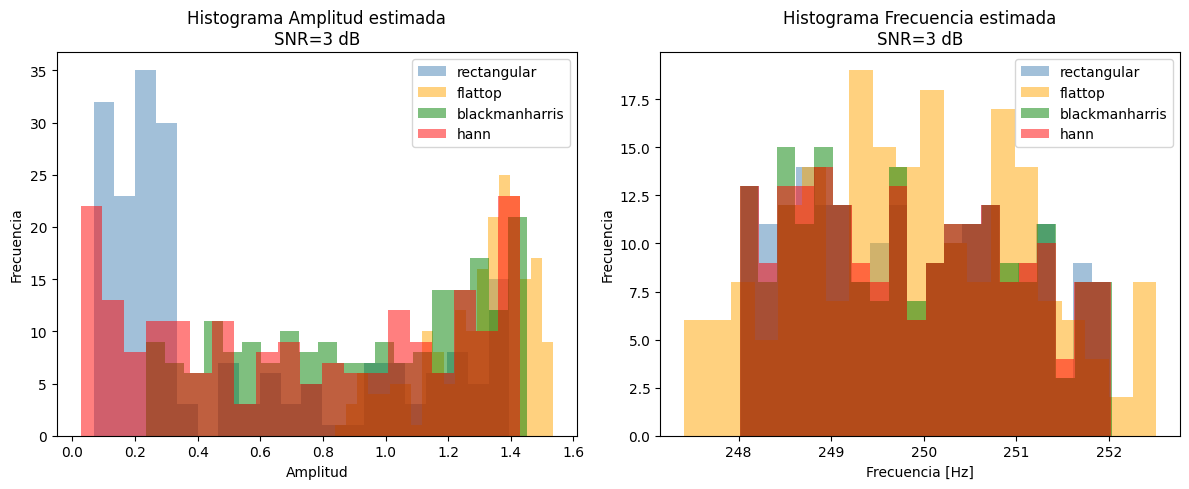


### Simulación con SNR = 10 dB ###

  Ventana: rectangular

  Ventana: flattop

  Ventana: blackmanharris

  Ventana: hann



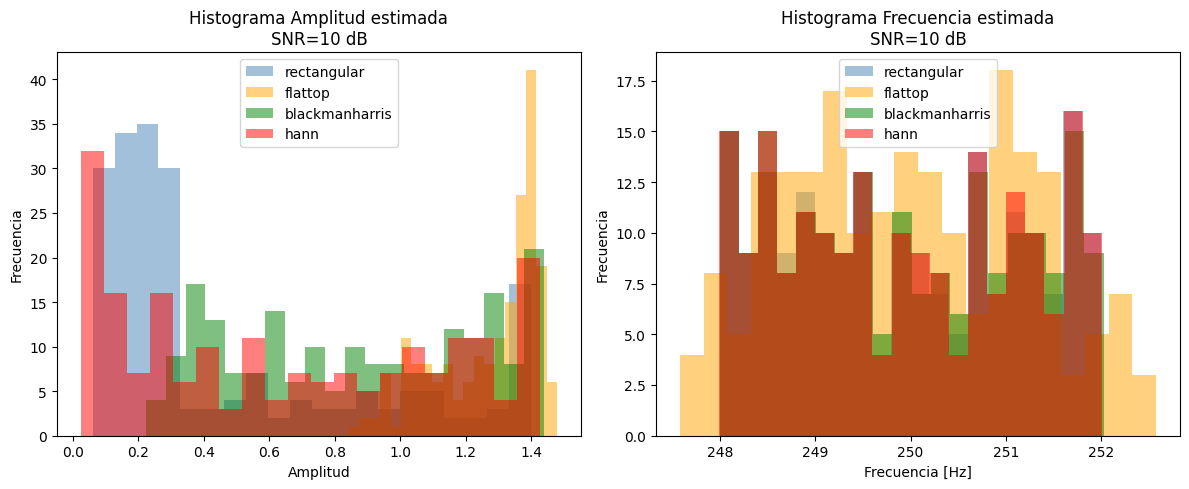


=== Estimación alternativa de Amplitud ===


,SNR [dB],Ventana,Sesgo,Varianza
0,3,rectangular,-0.899701,0.189026
1,3,flattop,-0.116350,0.026938
2,3,blackmanharris,-0.484310,0.136211
3,3,hann,-0.688697,0.223731
4,10,rectangular,-0.953816,0.173011
5,10,flattop,-0.143341,0.024694
6,10,blackmanharris,-0.541749,0.136572
7,10,hann,-0.762157,0.224833



=== Estimación alternativa de Frecuencia ===


,SNR [dB],Ventana,Sesgo,Varianza
0,3,rectangular,-0.002197,1.299997
1,3,flattop,0.035027,1.515228
2,3,blackmanharris,0.000703,1.300557
3,3,hann,-0.000471,1.299717
4,10,rectangular,0.000195,1.496664
5,10,flattop,0.013375,1.528819
6,10,blackmanharris,0.000549,1.493382
7,10,hann,0.000281,1.494760


(   SNR [dB]         Ventana     Sesgo  Varianza
 0         3     rectangular -0.899701  0.189026
 1         3         flattop -0.116350  0.026938
 2         3  blackmanharris -0.484310  0.136211
 3         3            hann -0.688697  0.223731
 4        10     rectangular -0.953816  0.173011
 5        10         flattop -0.143341  0.024694
 6        10  blackmanharris -0.541749  0.136572
 7        10            hann -0.762157  0.224833,
    SNR [dB]         Ventana     Sesgo  Varianza
 0         3     rectangular -0.002197  1.299997
 1         3         flattop  0.035027  1.515228
 2         3  blackmanharris  0.000703  1.300557
 3         3            hann -0.000471  1.299717
 4        10     rectangular  0.000195  1.496664
 5        10         flattop  0.013375  1.528819
 6        10  blackmanharris  0.000549  1.493382
 7        10            hann  0.000281  1.494760)

In [50]:
estimadores_alternativos(SNR_dbs, ventanas, N_fft=N*8)